# CS418 Gold Team Rules: A Look Into Chicago

UIC CS 418, Spring 2019


| Name            | NetID   | GitHub Handle  |
|-----------------|---------|----------------|
| Osama Ahmad     | oahmad7 | oahmad7        |
| Maxwell Dausch  | mdausc2 | mdausch        |
| Taj Atassi      | tatass2 | tajatassi      |
| Mohamed Saeed   | msaeed7 | MohamedSaeed99 |
| Abdullah Kidwai | akidwa2 | akidwhy        |


## Problem 
Our intention is to look for correlation between Chicago’s historical crime data, as well as permit data. We feel that this can aid in investment opportunities when combined with Chicago’s government owned land (Where plots of land are sold for $1)  One might be able to make a reasonable purchase, that can have a higher return on investment in the future.  


Our initial ideas are based around wondering if an area has a decreasing crime rate, while having an increasing “investment” area with rehabs, and new buildings, the area might be good for a future investment.
On the other hand, an increase in crime, might not be so good for investment, which we would then stay away from looking into properties in the area, and such investments might not turn a profit.
Some factors that might play a role in the increase/decrease of crime rate is the status of the area(poor/rich neighborhood).


This project will help people invest in the right area and know what to
expect from that area.


## Data

We are currently using a mix of Chicago data sets, each offering a different look into the city’s past and present.

A quick look into the data sets can be found below

### Crime Data
This will allow us to see how crime has changed over time, and the most common areas for crime [Download Data Set](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2)

 - 6,805,668 rows
 - 2001 - Present 
 - Location
 - Crime type
 - Dates of crime
 
 
### Permit Data
This will allow us to see how much certain areas are being invested in, and the types of renovations.
[Download Data Set](https://data.cityofchicago.org/widgets/ydr8-5enu)

 - 564,828 rows
 - 2006 - Present 
 - Location
 - Renovation type (New, Demolitions, Rehabs) 
 - Dates of permit application
 
 
### Land Data
This will allow us to see which Government owned land is for sale, while also being cheap.

[Download Data Set](https://data.cityofchicago.org/Community-Economic-Development/City-Owned-Land-Inventory/aksk-kvfp/data)

 - 15,932 rows
 - Location
 - Zoning Information
 - Square Footage

## What we hope to achieve 
To start off, we first would want to plot each of the data sets onto a map, that way we can compare them side by side, and check for inconsistencies, or correlations. Our next step would be to plot them all together, and adjust the time frames to see how the data has evolved.  

We envision that as a final product, the project will be dynamic, allowing us to see a full overview of the data, or by selecting a timeframe. Our goal is to make it visually easier for people to see which areas are available to buy and how that area is with crime. We also would like to predict which areas is going to be infested with crimes to prevent any bad investment choices.

## Changes to our original project proposal

As far as the scope of our project is concerned, we initially considered using real estate listings from scraping sites like Zillow or Realtor to obtain a more accurate representation of the general housing data. Due to time constants, we have decided to forgo this as it would make the data cleaning portion of our project too time consuming. Instead we are focusing our efforts on other aspect of the project, like the exploratory data analysis as well as the machine learning algorithm. 

Additionally, we have decided to use Flask Google Maps over Open Street Maps, Leaflet.js, and Matplotlib's Basemap Toolkit. Flask Google Maps align with our goals better and offer a more visually pleasant experience than the other options. 

## Obtaining the data¶
In order to use this notebook, you must download the data yourself, as there are limits on Github for data size.
Be sure to have the above data sets downloaded to the project folder as TSVs named:
 - Building_Permits.tsv
 - City-Owned_Land_Inventory.tsv
 - Crimes_-2001to_present.tsv
 
 
From here you will then create a database for each of the data sets


## Set Up Project Dependecies¶
You will first need to install the MySQL Connector
Install it with pip  
```pip install pymysql```  
```pip install flask```  
```pip install flask_googlemaps```  


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymysql
import sqlite3 as sql
import pandas as pd
import os
import os.path
import traceback
import matplotlib.pyplot as plt
import sklearn.model_selection as sk
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from flask import Flask, render_template
from flask_googlemaps import GoogleMaps
from flask_googlemaps import Map

## Build the databases
This assumes all the tsv files has beem created

In [3]:
# Functions needed to process a csv into a sqlite database
# This helps us get past the low memory errors that pandas gives us since our data is so large
def process(columns,columnString, valueString, chunk,cur):
    cur.executemany("INSERT INTO data VALUES (" + valueString +")", chunk.filter(items=columns).values.tolist())

def toDB(dbName, fileName,columns):

    #check if file exists
    PATH='./' + dbName

    if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
        print ("Database " + dbName + " already exists. Stopping.")
        return
    
    #open the connection to our db
    conn = sql.connect(dbName)
    cur = conn.cursor()
    
    #Get header
    numfields = pd.read_csv(fileName, delimiter='\t',nrows=1,skipinitialspace=1,encoding="utf-8-sig")

    #Build dynamic string for database query
    columnString = ""
    valueString = ""
    for column in columns:
        fixedC = column.replace(" ","_").replace(".","")
        columnString += fixedC + ", "
        valueString += "?, "
    columnString = columnString[0:-2].strip()
    valueString = valueString[0:-2].strip()

    #Create table
    try:
        cur.execute("Create table data (" + columnString + ")")
    except Exception: 
        traceback.print_exc()
        print ("Database " + dbName + " already exists. Stopping.")
        return
    

    print("Processing File: " + fileName)
    chunksize = 10 ** 4
    for chunk in pd.read_csv(fileName, chunksize=chunksize, delimiter='\t',skipinitialspace=1,encoding="utf-8-sig",low_memory=False):
        process(columns,columnString,valueString,chunk,cur)

    #close the db connection
    print("Done processing, now writing to database: " + dbName)
    conn.commit()
    cur.close()
    conn.close()



In [4]:
# Now we build the databases, while doing a bit of data cleaning in the process.
# First we need to list out what column names we want to keep
# This will build a table around those columns and insert the corresponding values into the database

#handle building permit data
dbColumns = ['ID','PERMIT_TYPE','ISSUE_DATE','TOTAL_FEE','WORK_DESCRIPTION','LATITUDE','LONGITUDE','LOCATION']
toDB("Building_Permits.db", "Building_Permits.tsv",dbColumns)

#handle city land data
dbColumns = ['ID','Property Status','Date of Acquisition','Date of Disposition','Sq. Ft.','Ward','Community Area Number','Community Area Name','Zip Code','X Coordinate','Y Coordinate','Latitude','Longitude','Location']
toDB("City-Owned_Land_Inventory.db", "City-Owned_Land_Inventory.tsv",dbColumns)

#handle crimes data (This will take a while)
dbColumns = ['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description','Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward','Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On','Latitude', 'Longitude', 'Location']

toDB("Crimes_-_2001_to_present.db", "Crimes_-_2001_to_present.tsv",dbColumns)

Database Building_Permits.db already exists. Stopping.
Database City-Owned_Land_Inventory.db already exists. Stopping.
Database Crimes_-_2001_to_present.db already exists. Stopping.


# Exploratory Data Analysis

In [8]:
def getYears(db):
    conn = sql.connect(db)
    cur = conn.cursor()

    #select all data for chicago
    cur.execute("SELECT DISTINCT YEAR FROM data ORDER BY Year ASC")

    #Get all values
    crimeCount = cur.fetchall()

    #Cleanup db connection
    cur.close()
    conn.close()
    
    years = []
    
    for c in crimeCount:
        years.append(c[0])
    
    return years
    
print(getYears('Crimes_-_2001_to_present.db'))

[2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


## Analysis
- Structure: The data is not very rectangular.
    - Some entries from City-owned_land_inventory are blank or just contain a PIN and nothing else
    - Positive: No Nested Data, so it becomes a little easier to manipulate
- Granularity: The data is very fine
    - They get very specific in terms of what buildings are available
    - Gives many details about the crime comitted such as Primary and secondary descriptions, location, and more
- Scope: The Data is mostly complete
    - Some entries are left blank in City-owned_land_inventory
    - Everything else is complete.
    - It has everything we need (Land, permits, and crimes) and not much extra
- Before Cleaning, the Data has different date ranges for each database, but has been truncated after cleaning
    - Crime Data: 2001-2019 -> 2006-2019
    - Permit Data: 2006-2019 -> 2006-2019
    - Land Data: Unknown
- The data has been captured and retrieved directly from the City of Chicago

### Other observations
- Observation: the fetchall and fetchone functions return a list of tuples even if you are retreiving one item, so we need to extract the the proper items and place them into lists
- After cleaning the data, the year of crimes spans 2006-Present.


## Visualizations

Below is a graph of Chicagos crimes through the years, starting from 2006 to the present. 
Overall we have seen a decrease in crime, though there is still quite a lot of crime. We will need to take this into account for our later research, and look for decreases of crime in individual areas, rather than the whole city.

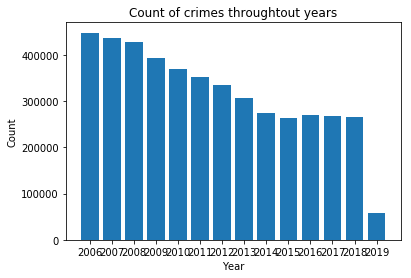

In [5]:
#Get connection to crimes database
conn = sql.connect("Crimes_-_2001_to_present.db")
cur = conn.cursor()

#select all data for chicago
cur.execute("SELECT COUNT(*) as count FROM data WHERE Year >= 2006 GROUP BY Year ORDER BY Year ASC")

#Get all values
crimeCount = cur.fetchall()

#Cleanup db connection
cur.close()
conn.close()

#Build visualization
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
countList = [count[0] for count in crimeCount]
plt.bar(years, countList)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of crimes throughtout years')
plt.show()

This next visualization features the types of permits that were granted in chicago, and which ones are more preval;ent in the city. Porch constuction is one of the lowest types of permits, which is what should be expected for the city, as. amajority of people live in apartment style buildings, rather than a house that has a porch. We are seeing lots of renovations, which could be a good sign for later on in our research progress.

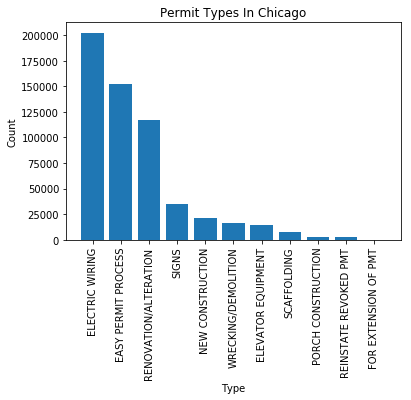

In [6]:
#Get connection to building permits database
conn = sql.connect("Building_Permits.db")
cur = conn.cursor()

#Get distinct counts for types of permits
cur.execute("SELECT PERMIT_TYPE,COUNT(*) as count FROM data GROUP BY PERMIT_TYPE ORDER BY count DESC")

#Get all values
permitTypes = cur.fetchall()

#Cleanup db connection
cur.close()
conn.close()

permits = []
permitsCount = []

for permit in permitTypes:
    permits.append(permit[0].replace("PERMIT - ",""))
    permitsCount.append(permit[1])

# #Build visualization
ax = plt.gca()
plt.figure(1, [20, 8])
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
plt.bar(permits,permitsCount)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Permit Types In Chicago')

# Set the x-axis limit
# Change of fontsize and angle of xticklabels

plt.show()

## Machine Learning

Below is our attempt at machine learning. We tried to use a neural net to classify the crimes data, by using a crime's lattitude and longitude.

After trying a mixture of settings, we found that the neural net should be built with two hidden layers, with two nodes each. This still did not work out well as our 10 fold cross validation error ended up being really high at .78

We feel that this is not the best we can do, Seeing this, it only tells us we should look into other styles of building machine learning models to see if better results could be found.

In [25]:
#Get connection to building permits database
conn = sql.connect("Crimes_-_2001_to_present.db")
cur = conn.cursor()

cur.execute("SELECT Latitude, Longitude FROM data WHERE Year >= 2006 AND Latitude IS NOT NULL AND Longitude IS NOT NULL AND Primary_Type IS NOT NULL")    
crimeLocation = cur.fetchall()

#Cleanup db connection
cur.close()
conn.close()

#Get connection to building permits database
conn = sql.connect("Crimes_-_2001_to_present.db")
cur = conn.cursor()

cur.execute("SELECT Primary_Type FROM data WHERE Year >= 2006 AND Latitude IS NOT NULL AND Longitude IS NOT NULL AND Primary_Type IS NOT NULL")
crimeType = cur.fetchall()

#Cleanup db connection
cur.close()
conn.close()


In [26]:
print("Splitting Data")
X_train, X_test, Y_train, Y_test = sk.train_test_split(crimeLocation, crimeType, test_size=0.8, train_size=0.2)

Splitting Data


In [27]:
xTrain = []
yTrain = []

for X in X_train:
    xTrain.append([X[0],X[1]])

for Y in Y_train:
    yTrain.append(Y[0])

a = np.array(yTrain)

print(a)


['NARCOTICS' 'CRIMINAL TRESPASS' 'NARCOTICS' ... 'NARCOTICS' 'THEFT'
 'BATTERY']


In [28]:
# print('lets begin')


# layer = [1,2,5]
# node = [2,5,10,50]
# minCVError = 1
# minNodes = 0
# minLayers = 0
# for layers in layer:
#     for nodes in node:
#         layers2 =()
#         for k in range(0,layers):
#                 layers2 += nodes,

#         nn = MLPClassifier(hidden_layer_sizes=layers2, max_iter=1000, activation='relu', solver='adam', epsilon=0.001, alpha=0)
#         nnModel = nn.fit(X_train, a)
#         cv2 = 1 - sk.cross_val_score(nnModel, X_train, a, cv=10, scoring='accuracy').mean()
#         print(cv2)
#         if(minCVError > cv2):
#             print("Found better model with lower CV Error" )
#             minCVError = cv2
#             minNodes = nodes
#             minLayers = layers
        
# print("Min CV Error is ", minCVError, ' with ', minNodes, ' nodes and ', minLayers, ' layers')

#Build model with optimal settings
nn = MLPClassifier(hidden_layer_sizes=[2,2], max_iter=1000, activation='relu', solver='adam', epsilon=0.001, alpha=0)
nnModel = nn.fit(X_train, a)

#Results of 10 fold cross validation 
print(" 10 fold cross validation: " + str(1 - sk.cross_val_score(nnModel, X_train, a, cv=10, scoring='accuracy').mean()))

/Users/mdausch/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


 10 fold cross validation: 0.7851956639059086


# Reflection

#### What is the hardest part of the project that you've encountered so far?

The hardest part of the project so far has been cleaning the data, specifically with the Crime Dataset. At a whopping 6.8 million rows, the Crime Dataset takes an incredibly long time to clean The extremely long time it took for us to group the crime data hindered our ability to continue to work on later portions of the project, because they were all reliant on the data cleaning to be done first.

#### What are your initial insights?

The biggest insight we have made is that the number of crimes over the course of our data set's time period has been gradually going down. It's currently unclear if those crime rates are in areas where investment is possible, or if the lower crime rates will effect the cost of land.

#### Are there any concrete results you can show at this point? If not, why not?

There are some concrete results we can show currently. Those results are evident in our visualization as well as our machine learning technique. 

#### Going forward, what are the biggest problems you're facing?

We are unsure what Machine Learning algorithm to apply to our data sets in the future. This problem is exacerbated by the fact that we ware unclear on what hypothesis is necessary to test for our data set. Most of our data is already incredibly detailed, and so we are struggling to find a place where using Machine Learning to predict and make some conclusion is necessary.

#### Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?

We are on track to complete the project on time, keeping the necessary standard of quality in mind. 

#### Given your initial exploration of the data, is it worth proceeding with your project, why? If not, how are you going to change your project and why do you think it's better than your current results?

We intend to continue working on our current project. We have already made some substantial insights into our project and intend on uncovering all that we can within this topic and present our results in a manner that is pleasant for the user.


# Next Steps

#### Here is how we are breaking down the work for the next few weeks to ensure we complete the assignment in a timely manner:

#### Week of 4/15:
- Submit the cleaned data and the scripts needed for cleaning
- Complete a machine learning technique and explanation
- Complete a distinct visualization of our data.

#### Week of 4/22:
- Complete a machine learning technique and explanation
- Complete a distinct visualization of our data.
- Complete preparing for the presentation on 4/29 or 5/1

#### Week of 4/29:
- Complete a distinct visualization of our data
- Fully analyze the results from our data